In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import random
from random import randint
import scipy.stats as st
from scipy import ndimage
import bisect
from numpy.linalg import svd, inv
%matplotlib inline

In [7]:
#The Gabor filters are not used here. They are better for recreating directional texture but the resulting pyramid is then
#unbalanced and reconstruction in not trivial anymore
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [8]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def CenterRGB(im):
    '''Function used for centering the image around 0. It is necessary to have an image with a mean of 0 to find the 
    decorralting transformation with a PCA'''
    rgb=np.copy(im)
    rgb[:,:,0]=rgb[:,:,0]-np.mean(rgb[:,:,0].ravel())
    rgb[:,:,1]=rgb[:,:,1]-np.mean(rgb[:,:,1].ravel())
    rgb[:,:,2]=rgb[:,:,2]-np.mean(rgb[:,:,2].ravel())
    return(np.array(rgb[:,:,0:3],dtype=np.float))

def RelocateRGB(Centered,rgb):
    '''Recentere the image　around its original mean values'''
    Centered[:,:,0]=Centered[:,:,0]+np.mean(rgb[:,:,0].ravel())
    Centered[:,:,1]=Centered[:,:,1]+np.mean(rgb[:,:,1].ravel())
    Centered[:,:,2]=Centered[:,:,2]+np.mean(rgb[:,:,2].ravel())
    return(np.array(Centered[:,:,0:3],dtype=np.float))

def FlatArray(a):
    '''Flattens a RGB array'''
    return(np.array([a[:,:,0].ravel(),a[:,:,1].ravel(),a[:,:,2].ravel()]).transpose())
    
def ExpandArray(a,L0,L1):
    '''Expands a RFB array'''
    NewArray=np.zeros([L0,L1,3])
    NewArray[:,:,0]=np.reshape(a[:,0],[L0,L1])
    NewArray[:,:,1]=np.reshape(a[:,1],[L0,L1])
    NewArray[:,:,2]=np.reshape(a[:,2],[L0,L1])
    return NewArray

def SVDmatrices(img):
    '''Computes the linear transformation that decorrelates the Data by computing the PCA of the flattened image'''
    a=CenterRGB(img)
    a2=np.array([a[:,:,0].ravel(),a[:,:,1].ravel(),a[:,:,2].ravel()])
    c=np.dot(a2,a2.transpose())
    U,s,V=svd(c)
    s=np.sqrt(s)
    M=np.dot(np.diag(np.divide(np.ones_like(s),s)),np.transpose(U))
    Minv=inv(M)
    return (Minv,M)

def DeCorrelate(imgFlat,M):
    '''Decorrelates the image using the transform found with the PCA'''
    DeCorr=np.zeros_like(imgFlat,dtype=np.float)
    for i in range(len(imgFlat)):
        DeCorr[i,:]=np.dot(imgFlat[i,:],M)
    return DeCorr

def ReCorrelate(imgFlat,Minv):
    '''Applies the inverse transformation to go back into the RGB space'''
    Transformed=np.zeros_like(imgFlat,dtype=np.float)
    for i in range(len(imgFlat)):
        Transformed[i,:]=np.dot(imgFlat[i,:],Minv)
    return Transformed

def Crop(Image):
    '''The image has to be cropped into a squared image with sides being a power of 2'''
    L=len(Image)
    l=len(Image[0])
    SizeL=np.int(np.log2(L))
    Sizel=np.int(np.log2(l))
    if 2**SizeL==L and 2**Sizel == l:
        return Image
    else:
        Side=min([SizeL,Sizel])
        Cropped=np.zeros([2**Side,2**Side,3])
        Cropped[:]=Image[int(L/2)-2**(Side-1):int(L/2)+2**(Side-1),int(l/2)-2**(Side-1):int(l/2)+2**(Side-1),:]
        return Cropped
    
    
def gkern(kernlen=21, nsig=3):
    '''Returns a Gaussian kernel in a np array, not used here since the filter is written by hand and always 5x5'''
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def Reduce(data):
    '''Operation used to create a low pass image'''
    b=SubSample(LowPassFilter(data))
    return b

def Expand(data):
    '''Operation used to create a part of the band pass image'''
    l=LowPassFilter(UpSample(data))
    return l

def SubSample(data):
    '''Scale the image down by a factor of 2 on both width and height'''
    Size=np.array(data.shape,dtype=np.int)/2
    return data[0::2,0::2]

def UpSample(data):
    '''Scales up the image by a factor of 2 by padding 0s'''
    Size=np.array(data.shape,dtype=np.int)*2
    UpSampled=np.zeros(Size)
    UpSampled[0::2,0::2]=data[:,:]
    return UpSampled

def LowPassFilter(data):
    '''Filters the image with a 5x5 Gaussian Filter'''
    Sfilter=2
    Filter2D=np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])*1/256.0
#     Filter2D=np.array([[1,-1,1],[0,0,0],[1,-1,1]])/2
    Result=ndimage.convolve(data, Filter2D, mode='wrap')
    return(Result)
    
class PyramidNode:
    '''Class for clarity'''
    def __init__(self,data):
        self.data=data
    def updateData(self,newdata):
        self.data=newdata

class Pyramid:
    '''Definition of the Pyramid class used to decompose the image into images of different resolution and frequencies'''
    def __init__(self,img):
        '''initialisation by creating the 1st low pass and band pass image of the intial image'''
        self.img=img
        self.depth=0
        self.Llist=[PyramidNode(Reduce(img))]
        self.Blist=[PyramidNode(img-Expand(self.Llist[0].data))]
        self.size=np.array(self.Llist[0].data.shape)

    def makePyramid(self,loop):
        '''Creates the decomposition in sub-bands for a depth of loop'''
        for i in range(loop):
            self.Llist.append(PyramidNode(Reduce((self.Llist[self.depth]).data)))
            self.Blist.append(PyramidNode(self.Llist[self.depth].data-Expand(self.Llist[self.depth+1].data)))
            self.depth=self.depth+1

    def getL(self,level):
        '''Gets the low pass Image of a given level'''
        if level<=self.depth:
            return(self.Llist[level].data)
        else:
            return 0

    def getB(self,level):
        '''Gets the Band pass image of a given level'''
        if level<=self.depth:
            return(self.Blist[level].data)
        else:
            return 0
    
    def updateL(self,level,data):
        self.Llist[level].updateData(data)
        
    def updateB(self,level,data):
        self.Blist[level].updateData(data)
    
    def CollapsePyramid(self):
        '''Recontructs the full Image by combining low and band pass images'''
        for i in range(self.depth,0,-1):
            self.updateL(i-1,Expand(self.getL(i))+self.getB(i))
        return Expand(self.getL(0))+self.getB(0)

def MatchHistogram(Noise,Sample):
    '''Matches histograms by sorting the lists and assigning the same values (no interpolation needed)'''
    M=len(Noise)
    N=len(Noise[0])
    BaseImRavel=np.copy(Sample).ravel()
    NoiseImRavel=np.copy(Noise).ravel()
    BaseSorted=np.argsort(BaseImRavel)
    NoiseSorted=np.argsort(NoiseImRavel)
    for i in range(M*N):
        NoiseImRavel[NoiseSorted[i]]=BaseImRavel[BaseSorted[i]]
    return np.reshape(NoiseImRavel,[M,N])

def MatchTexture(noise,texture,depth=5,loop=5):
    '''Single channel synthesis, takes noise and sample as arguments'''
    #Matches histogram of the noise image
    noise=MatchHistogram(noise,texture)
    #Creates a pyramid of both the sample and the noise image
    PyrText=Pyramid(texture)
    PyrText.makePyramid(depth)
    for i in range(loop):
        PyrNoise=Pyramid(noise)
        PyrNoise.makePyramid(depth)
        for j in range(depth):
            PyrNoise.updateB(j,MatchHistogram(PyrNoise.getB(j),
                                              PyrText.getB(j)))
        noise=PyrNoise.CollapsePyramid()
    noise=MatchHistogram(noise,texture)
    return noise

def ColorSynthesis(image,depth=2,loop=5):
    Cropped=Crop(image)
    Centered=CenterRGB(Cropped)
    L=Centered.shape
    L0=L[0]
    L1=L[1]
    M, Minv = SVDmatrices(Centered)
    imageFl=FlatArray(Centered)
    noiseRed=np.random.rand(L0, L1)
    noiseGreen=np.random.rand(L0, L1)
    noiseBlue=np.random.rand(L0, L1)
    imDeCorr=DeCorrelate(imageFl,M)
    imDeCorr=ExpandArray(imDeCorr,L0,L1)
    NoiseRed=MatchTexture(noiseRed,imDeCorr[:,:,0],depth,loop)
    NoiseGreen=MatchTexture(noiseGreen,imDeCorr[:,:,1],depth,loop)
    NoiseBlue=MatchTexture(noiseBlue,imDeCorr[:,:,2],depth,loop)
    Noise=np.zeros([L0,L1,3])
    Noise[:,:,0]=np.reshape(NoiseRed,[L0,L1])
    Noise[:,:,1]=np.reshape(NoiseGreen,[L0,L1])
    Noise[:,:,2]=np.reshape(NoiseBlue,[L0,L1])
    NoiseFl=FlatArray(Noise)
    RecorrelateImage=ReCorrelate(NoiseFl,Minv)
    Recentered=RelocateRGB(ExpandArray(RecorrelateImage,L0,L1),Cropped)
    Recentered[Recentered<0]=0
    Recentered[Recentered>1]=0.999
    return Recentered

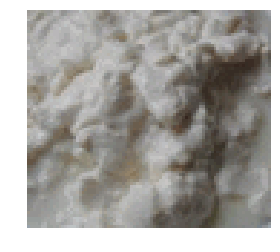

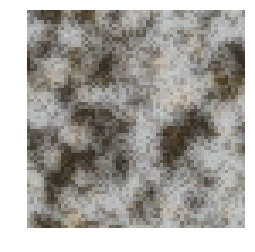

In [9]:
net=np.array(mpimg.imread('../../yogurt.gif'))[:,:,:3]/255.0
plt.imshow(net)
plt.axis('off')
plt.show()
a=ColorSynthesis(net,5,25)
a2=np.array(a)
plt.imshow(a2)
plt.axis('off')
plt.savefig('Density.png',dpi=300)

In [ ]:
git config --global user.name "plawinski"
git config --global user.email "jason.plawinski@gmail.com"